##まとめ
* 推論ベースの手法は、推論することを目標として、その副産物として単語の分散表現を得られる
* word2vecは推論ベースの手法であり、シンプルな２層のニューラルネットワークで構成される
* word2vecにはskip-gramモデルとCBOWモデルがある
* CBOWモデルは複数の単語（コンテキスト）から一つの単語（ターゲット）を推測する
* skip-gramモデルは逆に、一つの単語（ターゲット）から複数の単語（コンテキスト）を推測する
* word2vecは重みの再学習ができるため、単語の分散表現の更新や追加が効率的に行える

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


##推論ベースの手法とニューラルネットワーク

###ニューラルネットワークにおける単語の処理方法

In [ ]:
c=np.array([[1,0,0,0,0,0,0,]])  #入力（one-hot-vector）
W=np.random.randn(7,3)  #重み(入力の語彙数＊隠れ層のニューロン数)
h=np.dot(c,W)

print(h)

[[-1.18174929  0.63498083  0.23016874]]


In [ ]:
from common.layers import MatMul

c=np.array([[1,0,0,0,0,0,0,]])  #入力（one-hot-vector）
W=np.random.randn(7,3)  #重み(入力の語彙数＊隠れ層のニューロン数)
layer=MatMul(W)
h=layer.forward(c)

print(h)

[[-1.34191807 -0.35470282  1.37874722]]


##シンプルなword2vec

###CBOWモデルの推論処理
CBOWモデルはコンテキスト（ターゲットの周辺の単語）からターゲットを推測することを目的としたニューラルネットワーク

In [ ]:
from common.layers import MatMul

#サンプルのコンテキストデータ
c0=np.array([[1,0,0,0,0,0,0]])
c1=np.array([[0,0,1,0,0,0,0]])

#重みの初期化
W_in=np.random.randn(7,3)   #入力層の重みは各コンテキストで共有
W_out=np.random.randn(3,7)

#レイヤの生成(入力層のレイヤは考慮するコンテキスト数だけ用意する)
in_layer0=MatMul(W_in)
in_layer1=MatMul(W_in)
out_layer=MatMul(W_out)

#順伝搬
h0=in_layer0.forward(c0)
h1=in_layer1.forward(c1)
h=0.5*(h0+h1)   #入力層からの出力の平均を取る
s=out_layer.forward(h)

print(s)

[[ 3.06187034  2.15784129 -2.00320846 -1.140021   -1.72404717 -2.06319111
  -3.4427621 ]]


###CBOWモデルの学習
出力したスコアにソフトマックス関数を適用することで確率に変換  
その確率と教師ラベルから交差エントロピー誤差を求め、それを損失として学習を行う

###word2vecの重みと分散表現
word2vecの重みには入力側の重みと出力側の重みの二種類がある　　

最終的に利用する単語の分散表現としてどの重みを使うか？選択肢は３つ
1. 入力側の重みだけを利用する
2.  出力側の重みだけを利用する
3. ２つの重みの両方を利用する

word2vecに関しては、１が最もポピュラーな方法

##学習データの準備

###コンテキストとターゲット

In [ ]:
#前処理
from common.util import preprocess

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [ ]:
#corpusからcontextsとtargetを作成する関数
def create_contexts_target(corpus,window_size=1):
    target=corpus[window_size:-window_size]
    contexts=[]
    for idx in range(window_size,len(corpus)-window_size):
        cs=[]
        for t in range(-window_size,window_size+1):
            if t==0:    #tがターゲット自身の場合何もしない
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)

    return np.array(contexts),np.array(target)

In [ ]:
contexts,target=create_contexts_target(corpus,window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]



###one-hot表現への変換

In [ ]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換

    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [ ]:
from common.util import preprocess

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)   #前処理
contexts,target=create_contexts_target(corpus,window_size=1)    #corpusからcontextsとtargetを作成
vocab_size=len(word_to_id)
target=convert_one_hot(target,vocab_size)   #targetをone-hotに変換
contexts=convert_one_hot(contexts,vocab_size)   #contextsをone-hotに変換
print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


##CBOWモデルの実装

In [ ]:
from common.layers import MatMul,SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self,vocab_size,hidden_size):
        V,H=vocab_size,hidden_size

        #重みの初期化
        W_in=0.01*np.random.randn(V,H).astype('f')
        W_out=0.01*np.random.randn(H,V).astype('f')

        #レイヤの生成
        self.in_layer0=MatMul(W_in)
        self.in_layer1=MatMul(W_in)
        self.out_layer=MatMul(W_out)
        self.loss_layer=SoftmaxWithLoss()

        #すべての重みと勾配をリストにまとめる
        self.layers=[self.in_layer0,self.in_layer1,self.out_layer]
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

        #単語の分散表現をメンバ変数に設定
        self.word_vecs=W_in

    def forward(self,contexts,target):
        h0=self.in_layer0.forward(contexts[:,0])    #バッチ対応
        h1=self.in_layer1.forward(contexts[:,1])    #バッチ対応
        h=0.5*(h0+h1)   #入力層の出力の平均を取る
        score=self.out_layer.forward(h)
        loss=self.loss_layer.forward(score,target)

        return loss

    def backward(self,dout=1):
        ds=self.loss_layer.backward(dout)
        da=self.out_layer.backward(ds)
        da*=0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)

        return None

###学習コードの実装

In [8]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess,create_contexts_target,convert_one_hot

window_size=1
hidden_size=5
batch_size=3
max_epoch=1000

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)   #前処理

vocab_size=len(word_to_id)
contexts,target=create_contexts_target(corpus,window_size)  #コーパスからコンテキストとターゲットを生成
# print(contexts)
# print(target)
target=convert_one_hot(target,vocab_size)   #ターゲットをone-hot表記に変換
contexts=convert_one_hot(contexts,vocab_size)   #コンテキストをone-hot表記に変換
# print(contexts)
print(target)
# model=SimpleCBOW(vocab_size,hidden_size)
# optimizer=Adam()
# trainer=Trainer(model,optimizer)

# trainer.fit(contexts,target,max_epoch,batch_size)
# trainer.plot()

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [ ]:
word_vecs=model.word_vecs
for word_id,word in id_to_word.items():
    print(word,word_vecs[word_id])

you [-1.0857887 -1.0749503 -1.2508937 -1.041322   1.2807964]
say [1.1962563  1.1781354  1.190895   1.1840345  0.04180003]
goodbye [-0.82569355 -0.8508951  -0.5030469  -0.901656    0.71384275]
and [ 1.0266473  1.048476   1.0574095  1.0007217 -1.891177 ]
i [-0.81050414 -0.83914864 -0.48950097 -0.88104177  0.72082084]
hello [-1.0806098 -1.1020689 -1.2668185 -1.0687939  1.296239 ]
. [1.0063993  0.941933   0.96687937 1.020123   1.6274813 ]


##word2vecに関する補足

###CBOWモデルと確率
* CBOWモデルの確率による表記　　

    コンテキストとして$w_{t-1}$と$w_{t+1}$が与えられたときにターゲットが$w_t$となる確率

$$
P(w_t|w_{t-1},w_{t+1})\\
\begin{eqnarray}
w_t &:& ターゲット\\w_{t-1},w_{t+1} &:&コンテキスト 
\end{eqnarray}
$$

* 交差エントロピー誤差  
    $y_k$は「$k$番目に対応する事象が起こる確率」  

$$
L=-\sum _k t_k \log y_k
$$

* CBOWモデルの一つのデータに関する損失関数  

$$
L=-\log P(w_t|w_{t-1},w_{t+1})
$$

* CBOWモデルのコーパス全体に関する損失関数
$$
L=-\dfrac{1}{T}\sum^T_{t=1} \log P(w_t|w_{t-1},w_{t+1})
$$



###skip-gramモデル
ターゲット（中央の単語）からコンテキスト（周辺の単語）を推測する  
単語の分散表現の精度の点において、多くの場合でCBOWモデルよりも良い結果が得られる  
学習速度の点では、CBOWモデルの方がskip-gramよりも高速
* skip-gramモデルの確率による表記  
    $w_t$が与えられたときに、$w_{t-1}$と$w_{t+1}$が同時に起こる確率  

$$
P(w_{t-1},w_{t+1}|w_t)=P(w_{t-1}|w_t)P(w_{t+1}|w_t)
$$
* 交差エントロピー誤差に適用したskip-gramの損失関数（データ一つに対する損失関数）  

$$
\begin{eqnarray}
L&=&-\log P(w_{t-1}|w_t)P(w_{t+1}|w_t)\\&=&-(\log P(w_{t-1}|w_t))+\log P(w_{t+1}|w_t)
\end{eqnarray}
$$

* コーパス全体に対するskip-gramの損失関数  

$$
L=-\dfrac{1}{T}\sum^T_{t=1}((\log P(w_{t-1}|w_t))+\log P(w_{t+1}|w_t))
$$

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)   #入力は一つの単語（target）
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])    #出力は複数の単語（contexts）
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2  #各出力ごとの誤差の総和
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 21 |  iter 1 / 2 | ti

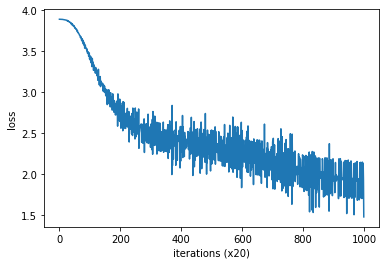

In [ ]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess,create_contexts_target,convert_one_hot

window_size=1
hidden_size=5
batch_size=3
max_epoch=1000

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
contexts,target=create_contexts_target(corpus,window_size)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)

model=SimpleSkipGram(vocab_size,hidden_size)
optimizer=Adam()
trainer=Trainer(model,optimizer)

trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()

In [ ]:
word_vecs=model.word_vecs
for word_id,word in id_to_word.items():
    print(word,word_vecs[word_id])

you [ 0.00185666 -0.00642814  0.00138951 -0.00570414  0.00103542]
say [ 0.60954136 -1.4373302  -0.5045882  -0.07580663  0.16310236]
goodbye [-0.7270303  0.785668   0.7150355  1.1396463 -1.0111978]
and [ 1.092177  -0.1953146 -1.1263338 -1.243041   1.2139776]
i [-0.73779947  0.7854246   0.6957962   1.1360115  -1.0063318 ]
hello [-1.0495781   1.1087596   1.0997624  -0.61598635  0.16961056]
. [ 0.01360205 -0.0052029  -0.01699429  0.0262869   0.01778184]


###カウントベースｖｓ推論ベース
* カウントベースの手法は、コーパス全体の統計データから１回の学習で単語の分散表現を得る  
* 推論ベースでは、コーパスの一部を何度も見ながら学習をする（ミニバッチ学習）  
* 語彙に新しい単語を追加するケースで、単語の分散表現を更新作業が発生した場合、カウントベースの手法では、ゼロから計算を行う必要がある(共起行列の作り直し、SVDによる次元削減のやり直し)  
* 推論ベースの手法（word2vec）では、パラメータの再学習（転移学習）が行える  
* カウントベースの手法では、主に単語の類似性がエンコードされることがわかっている  
* word2vec(特にskip-gram)では、単語の類似性に加えて、更に複雑な単語間のパターンも捉えられることがわかっている  
* 単語の類似性に関する定量評価に関していえば、推論ベースとカウントベースの手法には優劣がつけられないことが報告されている